### Deep Learning Supervised Text Classification
- BiLSTM (no data augmentation)

Bidirectional recurrent neural networks (RNN) put two independent RNNs together. This structure allows the networks to have both backward and forward information about the sequence at every time step


### Prepare Environment

In [ ]:
from numpy.random import seed
seed(156)
import tensorflow as tf
tf.random.set_seed(256)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab_Notebooks/safety_report_tc

/content/drive/MyDrive/Colab_Notebooks/safety_report_tc


In [ ]:
# Importing required libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm.std import tqdm
from IPython.display import display, HTML
from collections import Counter
import time
import textwrap
import json
import datetime

### Load Data

In [ ]:
# Pick a minority category of interest (base data from source)
focus_cats = [
    'hydraulic fluid or oil leak',
    'line strike',
    'site compliance or practice issue',
    'ppe non-compliance',
    'mechanical or equipment issue'
    ]

fns = [
    '2209031206', # hydraulic fluid or oil leak
    '2210031444', # line strike
    '2210031122', # site compliance or practice issue
    '2210031323', # ppe non-compliance
    '2210032046'  # mechanical or equipment issue
]

# Select a category to load
pick = input('Pick a category: ')
index = focus_cats.index(pick)
focus_cat = focus_cats[index]
fn = fns[index]
fn = f'01_data/prepared/{fn}_prepared_{focus_cat}_data.csv'

# Load data from a minority category of interest
df = pd.read_csv(fn)
df = df[['text', 'category']]
df = pd.read_csv(fn)
df

Pick a category: ppe non-compliance


,text,category
0,foreign body entered employee l eye while grin...,0
1,drainage pipe damaged at two two m depth see s...,0
2,robodrill spider excavator being operated when...,0
3,pressure hose made contact with light fitting ...,0
4,nacap 30t hitachi hyd hose split resultong in ...,0
...,...,...
93852,fall on water vehicle an employee was using an...,0
93853,other fall to lower level unspecified an emplo...,0
93854,injured by slipping or swinging object held by...,0
93855,direct exposure to electricity greater than tw...,0


### Data Preparation (Train / Test Splits)

In [ ]:
# Now create the input to the model training stage
X = df.text
y = df.category # Remember, these are not necessarily the 'truth' but rule_book hits

# Apply a simple 80/20 split
# TODO - The dataset is heavily imbalanced. Treat this appropriately.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234, stratify=y)

In [ ]:
base_train_count = len(X_train)
base_train_count

75085

In [ ]:
test_trues = list(y_test[y_test==1].index.values)
test_trues.sort()
print('Test:', len(test_trues), test_trues)

train_trues = list(y_train[y_train==1].index.values)
train_trues.sort()
print('Train:', len(train_trues), train_trues)

Test: 29 [810, 2274, 2318, 2808, 3139, 3341, 3740, 3785, 5268, 6543, 6598, 7792, 8781, 9597, 9977, 12529, 15069, 15074, 16849, 20307, 20529, 20546, 23834, 24312, 24476, 26295, 34384, 90941, 91446]
Train: 115 [9, 58, 188, 197, 1071, 1218, 1314, 1665, 1794, 1816, 2125, 2169, 2327, 2433, 2439, 2522, 2588, 2610, 2876, 3132, 3152, 3332, 3732, 4073, 4120, 4488, 4597, 4718, 4759, 4803, 4952, 5224, 5665, 5743, 6241, 6285, 6845, 7365, 7430, 7477, 8459, 8641, 8802, 8910, 9003, 9659, 9833, 9852, 9879, 10096, 10434, 10583, 11314, 11570, 11648, 11841, 11867, 12046, 12657, 12671, 12910, 13508, 13903, 14020, 14130, 14141, 14221, 14240, 14637, 14747, 14909, 15024, 15075, 15079, 15135, 15277, 15474, 15712, 15868, 16099, 16325, 16705, 16878, 17089, 17137, 18077, 18119, 18504, 19039, 19294, 19760, 20160, 20848, 21209, 21213, 21255, 21614, 22229, 22550, 23162, 23645, 23891, 24280, 24496, 25290, 26223, 26450, 32555, 33059, 36476, 36536, 38002, 45012, 49331, 74034]


In [ ]:
# Calculate imbalance in test dataset
imb = round(100* (Counter(y_test)[1] / Counter(y_test)[0]), 2)
print(f'"{focus_cat}"')
print(Counter(y_test))
print(f'Test data imbalance: {imb}%')

"ppe non-compliance"
Counter({0: 18743, 1: 29})
Test data imbalance: 0.15%


In [ ]:
# Look at training 'trues', i.e., rule-book hits
df_train_trues = df.iloc[train_trues]
df_train_trues.to_csv(f'01_data/prepared/df_train_trues_{focus_cat}.csv')
df_train_trues

,text,category
9,foreign body entered employee left eye whilst ...,1
58,worker observed without appropriate fall prote...,1
188,worker reported there was a very strong gust o...,1
197,worker reported there was a very strong gust o...,1
1071,whillst cleaning a ceiling ventilation grill d...,1
...,...,...
36536,other fall to lower level six to ten feet whil...,1
38002,other fall to lower level unspecified a worker...,1
45012,caught in running equipment or machinery durin...,1
49331,fall through surface or existing opening six t...,1


## Build Model

In [ ]:
# Load modelling building libraries
from keras.layers import Dropout, Dense, Embedding, LSTM, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn import metrics
from sklearn.utils import shuffle
from collections import Counter
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings
import logging
logging.basicConfig(level=logging.INFO)

In [ ]:
# Create a function to prepare model input sequences and embedding dictionary
def prepare_model_input(X_train, X_test, MAX_NB_WORDS=75000, MAX_SEQUENCE_LENGTH=500):
    np.random.seed(7)
    all_text = np.concatenate((X_train, X_test), axis=0)
    all_text = np.array(all_text)

    # Fit tokeniser only on training text
    text = np.array(X_train)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)

    # Save the tokenizer as .pkl file
    pickle.dump(tokenizer, open(f'08_output/{time.strftime("%y%m%d%H%M")}_text_tokenizer.pkl', 'wb'))

    # Generate sequences for all text using tokenizer created only on training text
    # This converts the sentence into a sequence of integers, e.g., [2, 4, 5, 7]
    sequences = tokenizer.texts_to_sequences(all_text)

    # Get a list of all words and their sequence numbers
    word_index = tokenizer.word_index

    # Pad out the sequences with zeroes to max sequence length
    all_text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    
    # Seperate training sequences from test
    X_train_Glove = all_text[0:len(X_train), ]
    X_test_Glove = all_text[len(X_train):, ]

    # Now gather the embeddings
    # Start with standard GloVe
    ## https://www.google.com/search?client=safari&rls=en&q=glove+embeddings&ie=UTF-8&oe=UTF-8
    embeddings_dict = {}
    f = open("03_embeddings/glove/glove.6B.50d.txt", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_dict[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_dict))
    return (X_train_Glove, X_test_Glove, word_index, embeddings_dict)


In [ ]:
# Create a function that builds the deep learning model
def build_bilstm(word_index, embeddings_dict, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5, hidden_layer = 3, lstm_node = 32):
    # Initialize a sequential model
    model = Sequential()
    
    # Make the embedding matrix using the embedding_dict
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
            
    # Add embedding layer
    print('_words', len(word_index))
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    # Add hidden layers 
    # Default will be 3 layers
    # Default lstm nodel number will be 32
    for i in range(0, hidden_layer):
        # Add a bidirectional lstm layer
        model.add(Bidirectional(LSTM(lstm_node, return_sequences=True, recurrent_dropout=0.2)))

        # Add a dropout layer after each lstm layer
        model.add(Dropout(dropout))

    model.add(Bidirectional(LSTM(lstm_node, recurrent_dropout=0.2)))

    # Attention addition
    #model.add(attention(return_sequences=True))
    
    model.add(Dropout(dropout))

    # Add the fully connected layer with 256 nuerons & Relu activation
    model.add(Dense(256, activation='relu'))

    # Add the output layer with softmax activation (binary output)
    model.add(Dense(nclasses, activation='softmax'))

    # Compile the model using sparse_categorical_crossentropy
    model.compile(loss='sparse_categorical_crossentropy', #'BinaryCrossentropy',
                      optimizer='adam',
                      metrics=["categorical_accuracy"])
    return model

In [ ]:
print("Preparing model input ...")
X_train_Glove, X_test_Glove, word_index, embeddings_dict = prepare_model_input(X_train, X_test)
print("Done!")

Preparing model input ...
Total 400000 word vectors.
Done!


In [ ]:
print("Building Model!")
model = build_bilstm(word_index, embeddings_dict, 2)
model.summary()

Building Model!
_words 58899
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 50)           2945000   
                                                                 
 bidirectional_4 (Bidirectio  (None, 500, 64)          21248     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 500, 64)           0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 500, 64)          24832     
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 500, 64)           0         
                                                                 
 bidirectional_6 (Bidirec

In [ ]:
# Quick view of rule_book hits (should represent the focus category)
X_test[y_test == 1].iloc[0]

'hand caught between two parts of a metal frame causing a cut to finger employee from subcontractor was erecting a tentlike structure to ensure one machine remains dry whilst on site the metal frame is comprised of various parts that fold and expand the injured person was opening up the frame and had his hand caught between two parts resulting in a cut to his little finger rh which required stitches the employee was not wearing gloves at the time of the incident the employee went immediately to hospital and was given two stitches in his finger he was also written off sick by the doctor treating him the employee went immediately to hospital and was given two stitches in his finger he was also written off sick by the doctor treating him'

### Model Training & Evaluatrion

In [ ]:
def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    f1 = (2*(precision*recall))/(precision+recall)
    return {
        "mcc": mcc,
        "true positive": tp,
        "true negative": tn,
        "false positive": fp,
        "false negative": fn,
        "precision" : precision,
        "recall" : recall,
        "F1" : f1,
        "accuracy": (tp+tn)/(tp+tn+fp+fn)
    }

def compute_metrics(labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()


In [ ]:
# Split training into training and validation data
X_train_vGlove, X_val_Glove, y_vtrain, y_val = train_test_split(X_train_Glove, y_train, test_size = 0.1, stratify=y_train, random_state = 1234)

# Verify stratification
num_pos_vTrain = len(y_vtrain[y_vtrain==1])
print(f'Number of positives in training (val) split: {num_pos_vTrain}')

num_pos_val = len(y_val[y_val==1])
print(f'Number of positives in validation data: {num_pos_val}')

Number of positives in training (val) split: 103
Number of positives in validation data: 12


In [ ]:
# Train the model

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

total_t0 = time.time()
print('Training for:', focus_cat)
epoch_num = int(input('Enter epoch number (default is 3): '))
history = model.fit(X_train_vGlove, y_vtrain,
                              validation_data=(X_val_Glove, y_val),
                              epochs=epoch_num,
                              batch_size=128,
                              verbose=1)

Training for: ppe non-compliance
Epoch 1/3
528/528 [==============================] - 1653s 3s/step - loss: 0.0187 - categorical_accuracy: 0.9990 - val_loss: 0.0118 - val_categorical_accuracy: 1.0000
Epoch 2/3
528/528 [==============================] - 1541s 3s/step - loss: 0.0108 - categorical_accuracy: 1.0000 - val_loss: 0.0100 - val_categorical_accuracy: 1.0000
Epoch 3/3
528/528 [==============================] - 1557s 3s/step - loss: 0.0074 - categorical_accuracy: 1.0000 - val_loss: 0.0104 - val_categorical_accuracy: 1.0000


In [ ]:
print(f'\nTotal training took {format_time(time.time()-total_t0)}')


Total training took 1:19:11


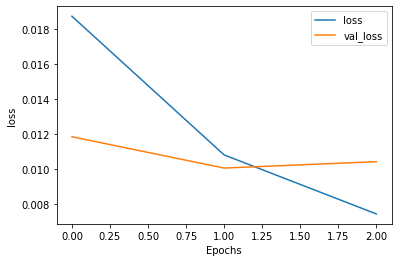

In [ ]:
# Plot training history
plot_graphs(history, 'loss')

In [ ]:
# load the model from disk
#fname = '2209181545_hydraulic fluid or oil leak_bilstm_model'
#filename = f'output/models/{fname}.pkl'
#model = pickle.load(open(filename, 'rb'))

In [ ]:
# Print accuracy measures
print(f'\n Evaluating Model for "{focus_cat}"... \n')

predicted = model.predict(X_test_Glove)
predicted = np.argmax(predicted, axis=1)

print(metrics.classification_report(y_test, predicted))
print("\n")
logger = logging.getLogger("logger")
result = compute_metrics(y_test, predicted)
for key in (result.keys()):
    logger.info("  %s = %s", key, str(result[key]))


 Evaluating Model for "ppe non-compliance"... 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18743
           1       0.00      0.00      0.00        29

    accuracy                           1.00     18772
   macro avg       0.50      0.50      0.50     18772
weighted avg       1.00      1.00      1.00     18772





/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: Run

In [ ]:
# Create dataframe for inspection of results
tmp = pd.DataFrame(X_test, columns=['text'])
tmp['pred'] = predicted
tmp['rule_book'] = y_test.values

# Quick look at predicted positives
print('Check rule-book hit count: ', len(tmp[tmp['rule_book']==1]))

Check rule-book hit count:  29


In [ ]:
Counter(y_test)

Counter({0: 18743, 1: 29})

In [ ]:
# Check a random selection of 'trues', i.e., rule-book hits...
# These should be consistent with the focis category, e.g., hydraulic fluid
table = tmp[(tmp['rule_book']==1)].sample(20)
display(HTML(table.to_html()))

,text,pred,rule_book
91446,other fall to lower level sixteen to twenty feet an employee was standing at the edge of the furnace pit and was going to push out the lining on the furnace the employee fell approximately twenty feet into the furnace tank and sustained broken vertebrae two broken ribs and a brain bleed the employee was not wearing fall protection at the time of the fall,0,1
8781,cut to left finger a hertel painter dropped a trowel the painter attempted to catch the trowel before it hit the ground and received a cut to his left finger initial reports suggest the ip was not wearing gloves the operative was treated on site by a first aider he later visited hospital and the cut was treated with paper stitches and glue hertel are undertaking an accident investigation the event has been categorised as first aid by senior hertel hse several hours passed after the event before the glue was applied the employer could not confirm if the ip had done further damage to the wound after the initial first aid was applied and he left work further to this when the employer asked for more details from the ip he confirmed that he requested medical glue himself as opposed to it being administered due to the severity of the wound,0,1
2318,"an employee received a splinter to the hand from handling a wood support he was wearing rubber gloves and did not change out gloves from the initial task of cleaning pipe the employee received first aid treatment to remove the splinter incident 37889at approximately one thousand and fifty-five am on forty-two thousand, six hundred and eighteen an employee switched from cleaning pipe which requires the use of rubber gloves to moving wooden pipe supports to store previously cleaned pipe the employee did not switch to his cut resistant gloves which are required to be worn when handling materialpipe supports when the employee picked up the wooden support his rubber glove and hand were punctured by a splinter although he removed the splinter immediately he was not sure he retrieved all of it from the small wound the employee was taken to the clinic for further evaluation due to localized swelling and the inability to see or determine whether or not there were any splinter fragments remaining in the wound the doctor determined that no fragments were remaining and he was released back to work with first aid treatment see detailed description",0,1
15069,"electrical technician suffered small laceration to finger while stripping umbilical cables task was the stripping of umbilical cables before commencing a glanding task ip was using a stanley knife to strip cabling which contains an inner lubricant following riser pulls upon cutting a new cable the knife slipped and made contact with his glove ninja knight cut resistance five resulting in an injury he did not immediately notice the injury until moving onto another cable to cut when discomfort was noted to his left index finger ip was wearing cut resistant gloves while using a stanley knife to remove the outer sheath of electrical umbilical cores exact type skytec ninja knight cut resistant four thousand, five hundred and forty-four knife was given proper approvals to be used on knife register and permit tool which was ordered could not remove the outer sheath no other option is available inner sheath of the cable has an electrical compound jelly which creates slippery type surfacewhile stripping the blade slipped due to the surface and nicked the ip on the finger going through the gloves ip reported to medic where laceration was examined and cleaned no further treatment given",0,1
24476,finger caught in training lifeboat hatch during the tempsc lifeboat component of an opito bosiet the ip caught their right index finger while releasing the port hatch the ip was not wearing the impact resistant gloves supplied wound flushed with water and band aid applied,0,1
5268,"release of hydraulic oil came into contact with persons right hand no injury incident 31779date tw

In [ ]:
# Examine precision stats
# Look at predicted positives that did not have a rule-book hit
table = tmp[(tmp['pred']==1) & (tmp['rule_book']==0)]
table.to_csv(f'10_performance/model_{focus_cat}_fps.csv')
display(HTML(table.to_html()))
total_pos_preds = len(tmp[(tmp['pred']==1)])
total_pos_hits = len(tmp[(tmp['pred']==1) & (tmp['rule_book']==1)])
print(f'\nThere are {len(table)} entries (out of {sum(y_test==1)})...')
print(f'\nTotal no. of positive predictions is  {total_pos_preds}...')
print(f'\nTotal no. of positive hits is  {total_pos_hits }...')

,text,pred,rule_book



There are 0 entries (out of 29)...

Total no. of positive predictions is  0...

Total no. of positive hits is  0...


In [ ]:
# Take a look at rule-book hits that did not have postive model hit...
table = tmp[(tmp['pred']==0) & (tmp['rule_book']==1)]
display(HTML(table.to_html()))
table.to_csv(f'10_performance/model_{focus_cat}_fns.csv', index=False)
table_count = len(table)
ruley_count = sum(y_test==1)
perc_calced = round(100*(table_count / ruley_count), 1)
print(f'\nThere are {table_count } entries (out of {ruley_count}, {perc_calced}%)...')


There are 29 entries (out of 29, 100.0%)...


### Save Model to Local Drive

In [ ]:
# Save the model
filename = f'08_output/models/{time.strftime("%y%m%d%H%M")}_{focus_cat}_bilstm_{epoch_num}_model.pkl'
pickle.dump(model, open(filename, 'wb'))

# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

### Inference Checks

In [ ]:
#text = ['fall lower level less six feet employee miss step fell stationary semitruck injure back']
#text = ["mini excavator develop small hydraulic leak remove pavement fluid contract concrete pavement area clean client notify migrate legacy cairs incident 34326on monday july thirty-one two thousand and seventeen celanese plant clear lake brazos e employee operate mini excavator develop small hydraulic leak remove pavement fluid contract concrete pavement area clean client notify migrate legacy cairs see detail description"]
#text = ['contact hot object substances employee transport hot drip fluid use cook oil container fluid contact employee cause first second degree burn']
#text = ['strike discharge object substance lineman work aerial lift leak break hydraulic line inject fluid hand hospitalize']
text_raw = 'dozer along right way small leak hose observe dozer right way small leak hydraulic hoseno contamination grind oil dozer notify operator damage hose contact strathclyde send fitter site repair'
text_raw = 'I was walking down the yard and I lost my footing and tripped and broke my leg'
text_raw = 'Employee noticed oil fluid leaking from hydraulic line'

In [ ]:
#with open('/content/drive/MyDrive/Colab_Notebooks/safety_report_tc/output/text_tokenizer.pkl', 'rb') as f:
#    tokenizer = pickle.load(f)

In [ ]:
# Create simple function for running inference on user input text
def inference_run():
    text_raw = input('Enter text:')
    # TODO - Apply text prep steps to user input steps
    text = [text_raw]
    text = np.array(text)
    text_all_tmp = np.concatenate((X_train, X_test), axis=0)
    text_tmp = np.array(X_train)
    tokenizer = Tokenizer(num_words=75000)
    tokenizer.fit_on_texts(text_tmp)

    sequences = tokenizer.texts_to_sequences(text)
    X_test_Glove_s = pad_sequences(sequences, maxlen=500)
    check_class = np.argmax(model.predict(X_test_Glove_s), axis=1)[0]
    if check_class == 1:
        # Use text wrap to avoid a paragraph of text printing as single line in output window
        lines = textwrap.wrap(text_raw, 80, break_long_words=False)
        for i, l in enumerate(lines):
            if i == 0:
                print(f'\n"{l}')
            elif i == len(lines)-1:
                print(f'{l}"')
            else:
                print(l)
        print('\nPredicted: ', focus_cat)
    else:
        print('\nNot classified...') 

In [ ]:
inference_run()

Enter text:dozer along right way small leak hose observe dozer right way small leak hydraulic hoseno contamination grind oil dozer notify operator damage hose contact strathclyde send fitter site repair

"dozer along right way small leak hose observe dozer right way small leak
hydraulic hoseno contamination grind oil dozer notify operator damage hose
contact strathclyde send fitter site repair"

Predicted:  hydraulic fluid or oil leak


### Random Undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [ ]:
len(X_train)

75085

In [ ]:
len(y_train)

75085

In [ ]:
# Reduce majority class to be X% of the majority class count
under = RandomUnderSampler(sampling_strategy=0.5, random_state=583) #183 
steps = [('u', under)]
pipeline = Pipeline(steps=steps)
X_train_Glove_us, y_train_us = pipeline.fit_resample(X_train_Glove, y_train)

In [ ]:
len(X_train_Glove_us)

1410

In [ ]:
counter = Counter(y_train_us)
print(counter)

Counter({0: 940, 1: 470})


In [ ]:
history_us = model.fit(X_train_Glove_us, y_train_us,
                              validation_data=(X_test_Glove, y_test),
                              epochs=4,
                              batch_size=128,
                              verbose=1)

Epoch 1/4
78/78 [==============================] - 316s 4s/step - loss: 0.2141 - categorical_accuracy: 0.9867 - val_loss: 0.0280 - val_categorical_accuracy: 0.9972
Epoch 2/4
78/78 [==============================] - 298s 4s/step - loss: 0.0976 - categorical_accuracy: 0.9624 - val_loss: 0.0282 - val_categorical_accuracy: 0.9876
Epoch 3/4
78/78 [==============================] - 294s 4s/step - loss: 0.0735 - categorical_accuracy: 0.9569 - val_loss: 0.0373 - val_categorical_accuracy: 0.9753
Epoch 4/4
78/78 [==============================] - 295s 4s/step - loss: 0.0654 - categorical_accuracy: 0.9497 - val_loss: 0.0249 - val_categorical_accuracy: 0.9874


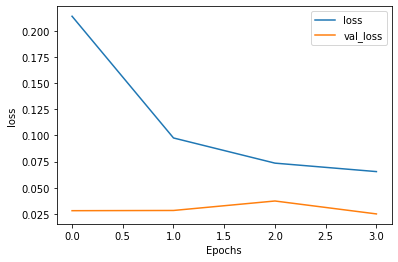

In [ ]:
# Plot training history
plot_graphs(history_us, 'loss')

In [ ]:
# Print accuracy measures
print("\n Evaluating Model ... \n")

predicted = model.predict(X_test_Glove)
predicted = np.argmax(predicted, axis=1)

print(metrics.classification_report(y_test, predicted))
print("\n")
logger = logging.getLogger("logger")
result = compute_metrics(y_test, predicted)
for key in (result.keys()):
    logger.info("  %s = %s", key, str(result[key]))


 Evaluating Model ... 

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     18665
           1       0.37      0.81      0.51       107

    accuracy                           0.99     18772
   macro avg       0.68      0.90      0.75     18772
weighted avg       1.00      0.99      0.99     18772





In [ ]:
# Create dataframe for inspection of results
tmp = pd.DataFrame(X_test, columns=['text'])
tmp['pred'] = predicted
tmp['rule_book'] = y_test.values

# Quick look at predicted positives
print('Check rule-book hit count: ', len(tmp[tmp['rule_book']==1]))

Check rule-book hit count:  107


In [ ]:
# Take a look at predicted positives that did not have a rule-book hit
table = tmp[(tmp['pred']==1) & (tmp['rule_book']==0)]
display(HTML(table.to_html()))
table.to_csv(f'10_performance/model_{focus}_fps.csv')
print(f"\nThere are {len(table)} 'false' positives ...")

,text,pred,rule_book
1068,"location pipeline services dj basindiesel overflow into secondary containment during restocking process by thirdparty fuel transport company no environmental contact incident 40228thirdparty fuel company hired transport haulertruck to restock fuel tanks at project laydown yard as the transport truck operator was pumping diesel into the storage tank he overflowed approximately fifty thousand, one hundred gallons of diesel into the lined secondarycontainment it is important to note the diesel fuel thatoverflowed by the hauler was fullycontained and the secondary containment was properly remediated by the fuel companynofuel diesel in this case ever touched the soil see detailed description",1,0
12085,a small amount of diesel was found to have leaked from a welfare unit which was positioned near c53 euchanhead a small amount of diesel was found to have leaked from a welfare unit which was positioned near c53 euchanhead spill kits were immediately deployed and the spill was contained on the track near where the welfare unit was located a large plant nappy was also positioned under the welfare units generator and fuel tank the contaminated material from the track was placed on visqueen and will be up lifted and disposed of in line with good environmental practiceno water courses were affected by this incident,1,0
21679,cp20210044 env nanjv 80l hydraulic oil an excavator was grubbing off the midgrade ore pad when a rock became stuck in the tracks as operator moved forward the rock impacted a cover plate buckling it which caused the plate to damage the 4inch hydraulic suction line causing 80l of hydraulic oil to be released to the ground work stopped and scene frozen spill pads were immediately placed on spill to contain area cleaned and disposed of contaminated soil,1,0
2005,"water being pumped from underground conduit leaked out of subcontractors vacc truck onto ground approximately twenty gallons work was stopped incident 38211at approximately one thousand, five hundred and thirty a subcontractors vacuum truck was used to vacuum particulate water from underground electrical conduit m1 the vacuum was released to switch over to conduit m2 and it was noticed that water was leaking from the back of the debusk vacuum truck the leak was noticed and stopped immediately resulting in approximately twenty gallons of particulate water being released to the ground the water was sampled for ph and determined to be at six see detailed description",1,0
3677,"adt seven hundred and forty pp106 experienced overflow of diesel due to heat expansion approx 05l diesel leaked out from the breather cap and dripped on the ground incident 34452wpa angore yard adt seven hundred and forty pp106 experienced overflow of diesel due to heat expansion approx 05l diesel leaked out from the breather cap and dripped on the ground the adt was refuelled at 6am this morning approx 40l the adt was parked up in wpa yard and not working where wpa yard what 05lt of diesel to grade when 23th august one thousand, five hundred hrs how fuel tank was over filled which facilitated expansion to occur other refuellers observed spill and cleaned up the machine and contaminated soil further actions refuelling team was stood down and spoke to on importance of not overfilling equipment see detailed description",1,0
9519,small fire on drive pto within ndd truck utilities bay crew members from subcontractor smelled strong odour of burning rubber emanating from services compartment within truck upon opening compartment door saw smoke and small flame escaping pto unit truck shut down immediately crew member used truck compartment dry chemical extinguisher to extinguish flame and cool pto unit rangedale mechanic called to inspect fault is local to pto unit within utilities only truck was operating in carpark area at the time,1,0
65245,inhalation of harmful substancesingle episode an employee was attempting to replace a pressure gauge on a hot gas ammonia line as t


There are 149 'false' positives ...


### Other Methods

#### Cat Boost

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [ ]:
import sklearn.model_selection
import sklearn.metrics
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Use Randomsearchcv to find good hyperparameters.
params = {'depth': [5, 6, 7, 8, 9],
 'learning_rate' : [0.0001, 0.001, 0.005, 0.01, 0.1],
 'l2_leaf_reg': [2, 4, 6, 8],
 'iterations': [100, 200, 300, 400]}
cb = CatBoostClassifier()
cb_model = RandomizedSearchCV(cb, params, verbose=1, cv=3, n_jobs=-1)
cb_model.fit(pd.DataFrame(X_train_Glove), y_train.astype(float), verbose=0)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f4258830e10>,
                   n_jobs=-1,
                   param_distributions={'depth': [5, 6, 7, 8, 9],
                                        'iterations': [100, 200, 300, 400],
                                        'l2_leaf_reg': [2, 4, 6, 8],
                                        'learning_rate': [0.0001, 0.001, 0.005,
                                                          0.01, 0.1]},
                   verbose=1)

In [ ]:
cb_model.best_params_

{'learning_rate': 0.001, 'l2_leaf_reg': 2, 'iterations': 400, 'depth': 6}

In [ ]:
def run_catboost (X, y):
    # split into train and CV data
    n_splits = 5
    splits = list(sklearn.model_selection.StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2019).split(X, y))

    models = []
    scores = np.zeros(n_splits)

    print('Training...')

    for i, (idx_train, idx_cv) in enumerate(splits):
        print(f'\nCV Split {i+1} Confusion Matrix:')
        X_train = X.iloc[idx_train, :]
        y_train = y.iloc[idx_train]

        X_cv = X.iloc[idx_cv, :]
        y_cv = y.iloc[idx_cv]

        # Learning rate is important; large values overfit the data
        model = CatBoostClassifier(learning_rate=0.001, depth=6, l2_leaf_reg=2, od_type='IncToDec',
                                loss_function='Logloss', use_best_model=True, eval_metric='MCC')

        model.fit(X_train, y_train.astype(float), silent=True,
                  eval_set=(X_cv, y_cv.astype(float)))

        y_predict_train = model.predict(X_train)
        y_predict_cv = model.predict(X_cv)

        score_train = sklearn.metrics.matthews_corrcoef(y_train, y_predict_train)
        score_cv = sklearn.metrics.matthews_corrcoef(y_cv, y_predict_cv)

        models.append(model)
        scores[i] = score_cv

        print(sklearn.metrics.confusion_matrix(y_cv, y_predict_cv))
        print('\nRecall: ', round(sklearn.metrics.recall_score(y_cv, y_predict_cv), 2))
        print('Precision: ', round(sklearn.metrics.precision_score(y_cv, y_predict_cv), 2))

        #print('%d %.3f %.3f' % (i, score_train, score_cv))
    
    return(model)
    print('\nCV MCC scores %.3f ± %.3f' % (np.mean(scores), np.std(scores)))

In [ ]:
# Train the CatBoost Model on the base data
catboost_model = run_catboost(X=pd.DataFrame(X_train_Glove_us), y=y_train_us)

Training...

CV Split 1 Confusion Matrix:
[[158  30]
 [ 42  52]]

Recall:  0.55
Precision:  0.63

CV Split 2 Confusion Matrix:
[[151  37]
 [ 29  65]]

Recall:  0.69
Precision:  0.64

CV Split 3 Confusion Matrix:
[[164  24]
 [ 46  48]]

Recall:  0.51
Precision:  0.67

CV Split 4 Confusion Matrix:
[[160  28]
 [ 39  55]]

Recall:  0.59
Precision:  0.66

CV Split 5 Confusion Matrix:
[[156  32]
 [ 28  66]]

Recall:  0.7
Precision:  0.67


In [ ]:
y_predict_test = catboost_model.predict(X_test_Glove)
print(Counter(y_test), '\n')
conf_mat_cb = sklearn.metrics.confusion_matrix(y_test, y_predict_test)
false_alarms = round(100*conf_mat_cb[0, 1] / conf_mat_cb[0, 0], 1)
print(conf_mat_cb)
print('\nRecall: ', round(sklearn.metrics.recall_score(y_test, y_predict_test), 2))
print('Precision: ', round(sklearn.metrics.precision_score(y_test, y_predict_test), 2))
print('F beta: ', round(sklearn.metrics.fbeta_score(y_test, y_predict_test, beta=2), 2))
print(f'False Alarms: {false_alarms}%')

Counter({0: 18665, 1: 107}) 

[[15988  2677]
 [   45    62]]

Recall:  0.58
Precision:  0.02
F beta:  0.1
False Alarms: 16.7%


#### Logistic Regression

In [ ]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
X_train_Glove_sc = scaler.fit_transform(X_train_Glove)

In [ ]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train_Glove_sc, y_train)

LogisticRegression(max_iter=3000)

In [ ]:
lr_clf.score(X_test_Glove, y_test)

0.7802578308118474

In [ ]:
y_predicted = lr_clf.predict(X_test_Glove)

In [ ]:
cnf = metrics.confusion_matrix(y_test, y_predicted)
cnf

array([[14590,  4075],
       [   50,    57]])

In [ ]:
lr_recall = round(cnf[1, 1] / (cnf[1, 0] + cnf[1, 1]), 2)
print(f'Logistic regression recall = {lr_recall}')
lr_prec = round(cnf[1, 1] / (cnf[0, 1] + cnf[1, 1]), 2)
print(f'Logistic regression precision = {lr_prec}')

Logistic regression recall = 0.53
Logistic regression precision = 0.01


#### SVM

In [ ]:
from sklearn.svm import OneClassSVM
# Train a one-class SVM 
svm_model =  OneClassSVM(nu = 0.005) # 0.5%
svm_model.fit(pd.DataFrame(X_train_Glove))

OneClassSVM(nu=0.005)

In [ ]:
preds_svm = pd.Series(svm_model.predict(X_test_Glove)).map({1: 0, -1: 1})
preds_svm = pd.DataFrame({'prediction':preds_svm})
preds_svm['rule_book'] = y_test.reset_index(drop=True)
preds_svm[(preds_svm['prediction']==1) & (preds_svm['rule_book']==1)]

,prediction,rule_book
1227,1,1
2751,1,1
2829,1,1
6492,1,1
10474,1,1
17640,1,1
17957,1,1


In [ ]:
# Check metrics
svm_ta = len(preds_svm[(preds_svm['rule_book']==1)])
svm_tp = len(preds_svm[(preds_svm['prediction']==1) & (preds_svm['rule_book']==1)])
svm_fp = len(preds_svm[(preds_svm['prediction']==1) & (preds_svm['rule_book']==0)])
svm_pp = len(preds_svm[(preds_svm['prediction']==1)])

prec = svm_tp/svm_pp
reca = svm_tp/svm_ta

print(f'Precision: {round(prec, 2)}')
print(f'Recall: {round(reca, 2)}')

Precision: 0.01
Recall: 0.07
